<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter3/3_5_%E9%9A%8E%E5%B1%A4%E3%83%99%E3%82%A4%E3%82%BA%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
#!pip install pymc3==3.11.4
!pip install pymc3
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.8 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=fed3dd6e4da4b4d13560c65d879ecaef4ce6ce664371ce878e97a773fecc2842
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import japanize_matplotlib

sns.set_context('talk', font_scale=0.8)

In [ ]:
np.random.seed(12)
group_num = 9
data_num = 25

a_vector = np.random.normal(1000.0, scale=100.0, size=group_num)
b_vector = np.random.normal(50000.0, scale=500.0, size=group_num)

x_data = np.random.uniform(20, 50, data_num)

group_idx = np.random.randint(0, group_num, data_num)
y_data = a_vector[group_idx] * x_data + b_vector[group_idx] + np.random.normal(0, scale=1500.0, size=data_num)

x_data = np.append(x_data, 33.322)
y_data = np.append(y_data, 75004.54)
group_idx = np.append(group_idx, 8)

# # データ読み込み
#df_data = pd.read_csv('toy_data.csv')
# # 真の係数パラメータデータ
#df_coef = pd.read_csv('true_corf.csv')

df_data = pd.DataFrame([x_data, y_data, group_idx]).T
df_data.columns = ['x', 'y', 'systemID']

df_coef = pd.DataFrame([a_vector, b_vector]).T
df_coef.columns = ['a', 'b']

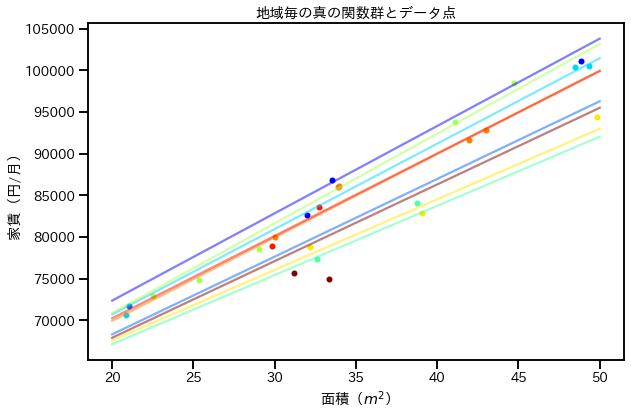

In [ ]:
# 説明変数
x_data = df_data['x'].values
# 目的変数
y_data = df_data['y'].values
# 地域グループ
group_idx = df_data['systemID'].values.astype(int)
# 地域毎の傾きとバイアス
a_vector, b_vector = df_coef['a'].values, df_coef['b'].values

# 可視化用
x_linspace = np.linspace(20, 50, 100)

fig, ax = plt.subplots(figsize=(9, 6))
cm10 = plt.get_cmap('jet', 10)
for i in range(9):
  # 真の関数可視化
  ax.plot(x_linspace, a_vector[i]*x_linspace+b_vector[i], color=cm10(i+1), alpha=0.5)
  # 学習データ可視化
  ax.scatter(x_data[group_idx==i], y_data[group_idx==i], marker='.', color=cm10(i+1))

ax.set_xlabel('面積（$m^2$）');ax.set_ylabel('家賃（円/月）')
ax.set_title('地域毎の真の関数群とデータ点')
plt.tight_layout()

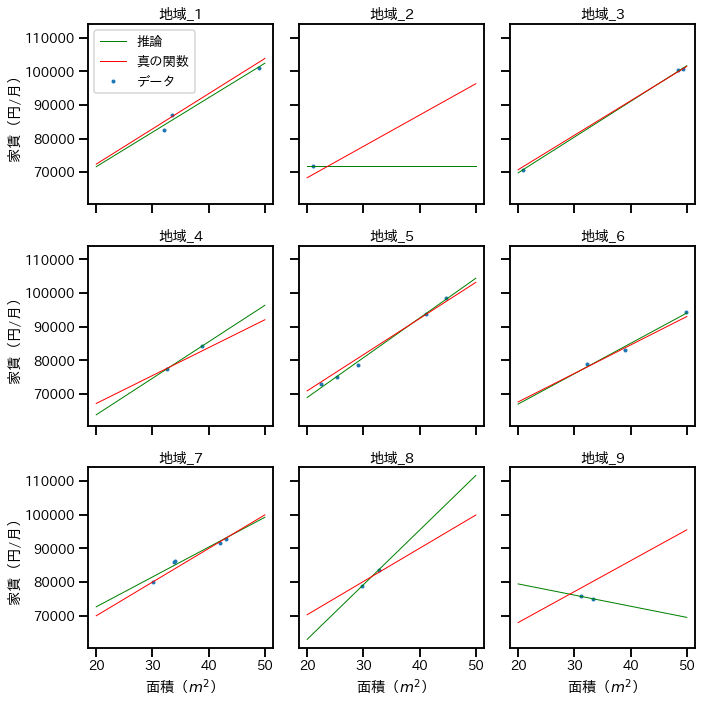

In [ ]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, sharex=True, sharey=True)
x_new = np.linspace(20, 50, 100)

# 地域グループ毎に処理
for i in range(9):
  row_index = i//3
  col_index  = i%3

  # 地域グループ取り出し
  x_i = x_data[group_idx==i]
  y_i = y_data[group_idx==i]
  # 線形回帰
  lr = LinearRegression()
  lr.fit(x_i.reshape(-1,1), y_i.reshape(-1,1))            

    # 線形回帰可視化
  y_linear_model = lr.predict(x_new.reshape(-1,1))
  ax[row_index, col_index].plot(x_new, y_linear_model, color = 'green',\
  linewidth = 1, label='推論')
  # 真の関数可視化
  y_true = a_vector[i]*x_new+b_vector[i]
  ax[row_index, col_index].plot(x_new, y_true, color = 'red',\
  linewidth = 1, label='真の関数')
  # 学習データ可視化
  ax[row_index, col_index].scatter(x_i, y_i, marker='.', s=25,\
  zorder=2, label='データ')
  
  ax[row_index, col_index].set_title('地域_{}'.format(i+1))  
  if row_index==2:
    ax[row_index, col_index].set_xlabel('面積（$m^2$）')
  if col_index==0:
    ax[row_index, col_index].set_ylabel('家賃（円/月）')
 
ax[0,0].legend()
plt.tight_layout()

In [ ]:
import pymc3 as pm

In [ ]:
# モデルの定義
with pm.Model() as model:

    # 説明変数
    X_shared = pm.Data("x", x_data)

    # 傾きについてのハイパーパラメータの事前分布
    a_mu = pm.Normal('a_mu', mu=50.0, sigma=10.0)
    a_sigma = pm.HalfCauchy('a_sigma', beta=100.0)

    # 地域毎の傾き
    a_offset = pm.Normal('a_offset', mu=a_mu, sigma=a_sigma, shape=group_num)

    # バイアスについてのハイパーパラメータの事前分布
    b_mu = pm.Normal('b_mu', mu=50000.0, sigma=1000.0)
    b_sigma = pm.HalfCauchy('b_sigma', beta=1000.0)
    
    # 地域毎のバイアス
    b_offset = pm.Normal('b_offset', mu=b_mu, sigma=b_sigma, shape=group_num)

    # 尤度関数
    y = pm.Normal('y', mu=a_offset[group_idx]*X_shared + b_offset[group_idx], sigma=1000, observed=y_data)

In [ ]:
with model:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [b_offset, b_sigma, b_mu, a_offset, a_sigma, a_mu]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 73 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


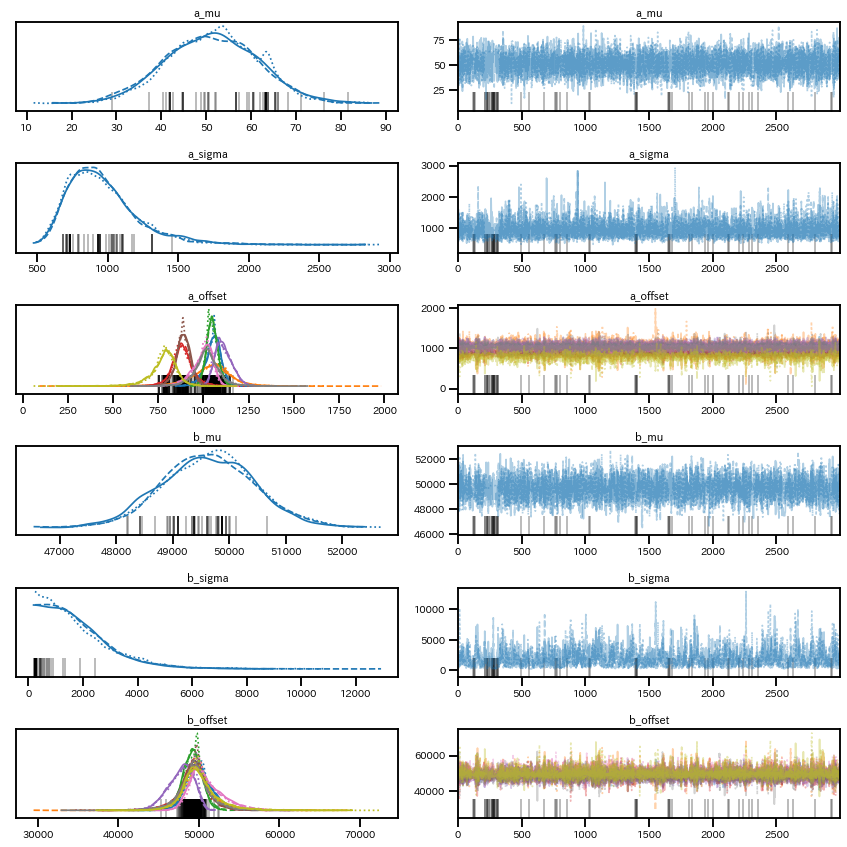

In [ ]:
az.plot_trace(trace, var_names=['a_mu', 'a_sigma', 'a_offset', 'b_mu', 'b_sigma', 'b_offset']);
plt.tight_layout();

In [ ]:
for var_info in az.rhat(trace).values():
  print(var_info.name, var_info.values.round(3))

a_mu 1.001
a_offset [1.002 1.    1.001 1.001 1.001 1.001 1.002 1.001 1.002]
b_mu 1.003
b_offset [1.002 1.001 1.001 1.002 1.001 1.001 1.002 1.001 1.001]
a_sigma 1.002
b_sigma 1.005


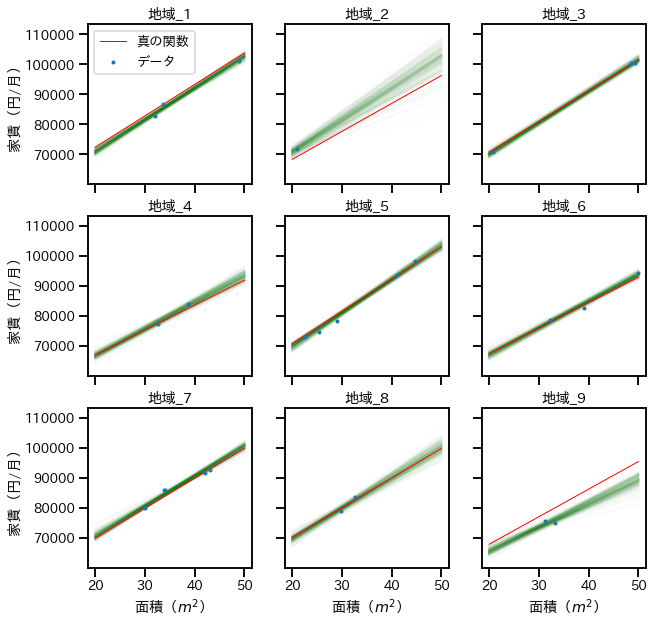

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, sharex=True, sharey=True)
x_new = np.linspace(20, 50, 100)

# 地域グループ毎に処理
for i in range(9):
  row_index = i//3
  col_index  = i%3

  # 地域ごとの係数パラメータのMCMCサンプル平均値と標準偏差を算出
  a_i_mcmc_samples = trace.posterior['a_offset'][0, :, i]
  b_i_mcmc_samples = trace.posterior['b_offset'][0, :, i]
  
  # 学習データ可視化
  x_i = x_data[group_idx==i]
  y_i = y_data[group_idx==i]
  ax[row_index, col_index].scatter(x_i, y_i, marker='.', zorder=3, s=25, label='データ')
  
  # MCMCサンプルを使って予測分布の平均を可視化
  for k in range(0, 3000, 15):
    y_new_sample = a_i_mcmc_samples[k].values * x_new + b_i_mcmc_samples[k].values
    ax[row_index, col_index].plot(x_new, y_new_sample, alpha=0.01, color ='green', zorder=1)
    
  # 真の関数可視化
  y_true = a_vector[i]*x_new+b_vector[i]
  ax[row_index, col_index].plot(x_new, y_true, color = 'red',\
  linewidth = 1, label='真の関数')
  
  ax[row_index, col_index].set_title('地域_{}'.format(i+1))
  if row_index==2:
    ax[row_index, col_index].set_xlabel('面積（$m^2$）')
  if col_index==0:
    ax[row_index, col_index].set_ylabel('家賃（円/月）')
ax[0, 0].legend();

In [ ]:
%load_ext watermark
%watermark --iversions

scipy              : 1.4.1
IPython            : 5.5.0
matplotlib         : 3.2.2
arviz              : 0.12.1
pymc3              : 3.11.4
japanize_matplotlib: 1.1.3
seaborn            : 0.11.2
numpy              : 1.21.6
pandas             : 1.3.5

